In [2]:
# Преоразовать существующий код для распознавания последовательности рукописных символов в текст.
# Написать генератор произвольной последовательности рукописных символов.

# ГЕНЕРАЦИЯ НАБОРА ДАННЫХ
# Сгенерировать набор текстовых строк из допустимых символов.
# Каждому набору поставить в соотвествие массив изоражений соответствующих символов.
# Добавить пробелы для разделения слов, символы пробелов не использовать во время классификации.

# КЛАССИФИКАЦИЯ (k ближайших соседей) (пример AIM practice 2)
# Часть символов оставить для обучения классификатора . Остальные  классифицировать
# по аналогии с примером mnist с прошлого занятия. Т.е. преобразовывать изображение в вектор.
# Выбрать оптимальный классификатор в зависимости от k- количество соседей.
# Метрика для измерения точности классификации, и выбора оптимального классификатора относительно параметра k - accuracy.

# РАСПОЗНАВАНИЕ
# заменить inf_net на последовательное применение следующих шагов:
# 1. генерация изображения с последовательностью символов
# 2. Выделение объектов оставляете как есть.
# 3. Примернить k-nn для решения задачи классификации. 
# 4. Вывести результат

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from sklearn.neighbors import KNeighborsClassifier

In [9]:
class SymbolSequenceGenerator:
    def __init__(self, base_dir):
        self.base_dir = base_dir
        self.symbols_list = ['(', ')', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 't', 'x', 'y', ',', '+', '-', '*']
        print("Символы в датасете:", ', '.join(self.symbols_list))
    
    def pick_symbol_img(self, symbol):
        folder = symbol if symbol not in ['x', '*'] else ('X' if symbol == 'x' else 'times')
        symbol_folder = os.path.join(self.base_dir, folder)
        all_imgs = sorted(os.listdir(symbol_folder))
        split_idx = int(len(all_imgs) * 0.8)
        valid_imgs = all_imgs[split_idx:] if len(all_imgs) > split_idx else all_imgs
        chosen_file = random.choice(valid_imgs)
        path_to_img = os.path.join(symbol_folder, chosen_file)
        return cv2.imread(path_to_img, cv2.IMREAD_GRAYSCALE)
    
    def make_sequence(self, seq_len=4):
        seq_text = ''.join(random.choices(self.symbols_list, k=seq_len))
        print(f"[SEQ] Генерируем строку: {seq_text}")
        imgs = [self.pick_symbol_img(char) for char in seq_text]
        return seq_text, imgs

seq_gen = SymbolSequenceGenerator(r'C:\Users\smeta\Downloads\data')

Символы в датасете: (, ), 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, t, x, y, ,, +, -, *


[SEQ] Генерируем строку: )y8335*8)


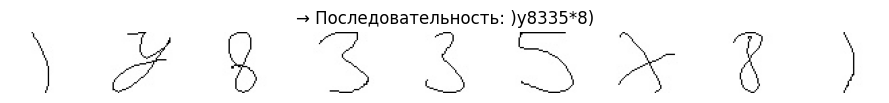

In [10]:
def stitch_sequence(images, gap=25):
    heights = [img.shape[0] for img in images]
    max_h = max(heights)
    total_w = sum(img.shape[1] for img in images) + gap * (len(images) - 1)
    composed = np.full((max_h, total_w), 255, dtype=np.uint8)
    x = 0
    for img in images:
        y = (max_h - img.shape[0])
        composed[y:y + img.shape[0], x:x + img.shape[1]] = img
        x += img.shape[1] + gap
    return composed

text_seq, seq_imgs = seq_gen.make_sequence(seq_len=9)
stitched_img = stitch_sequence(seq_imgs, gap=30)

plt.figure(figsize=(9, 4))
plt.imshow(stitched_img, cmap='gray')
plt.title(f'→ Последовательность: {text_seq}')
plt.axis('off')
plt.tight_layout()
plt.show()

→ Детектируем объекты на строке: ')y8335*8)'


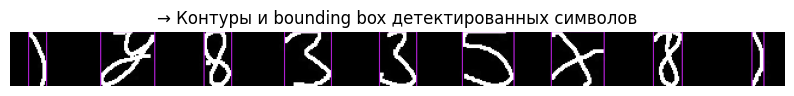

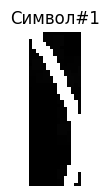

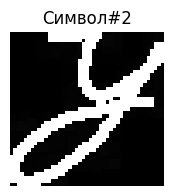

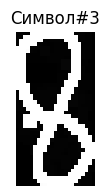

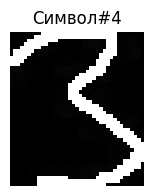

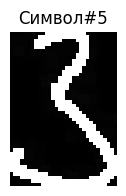

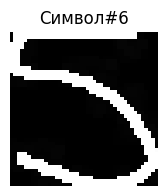

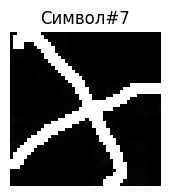

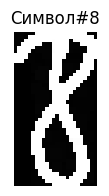

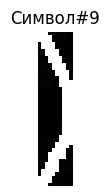

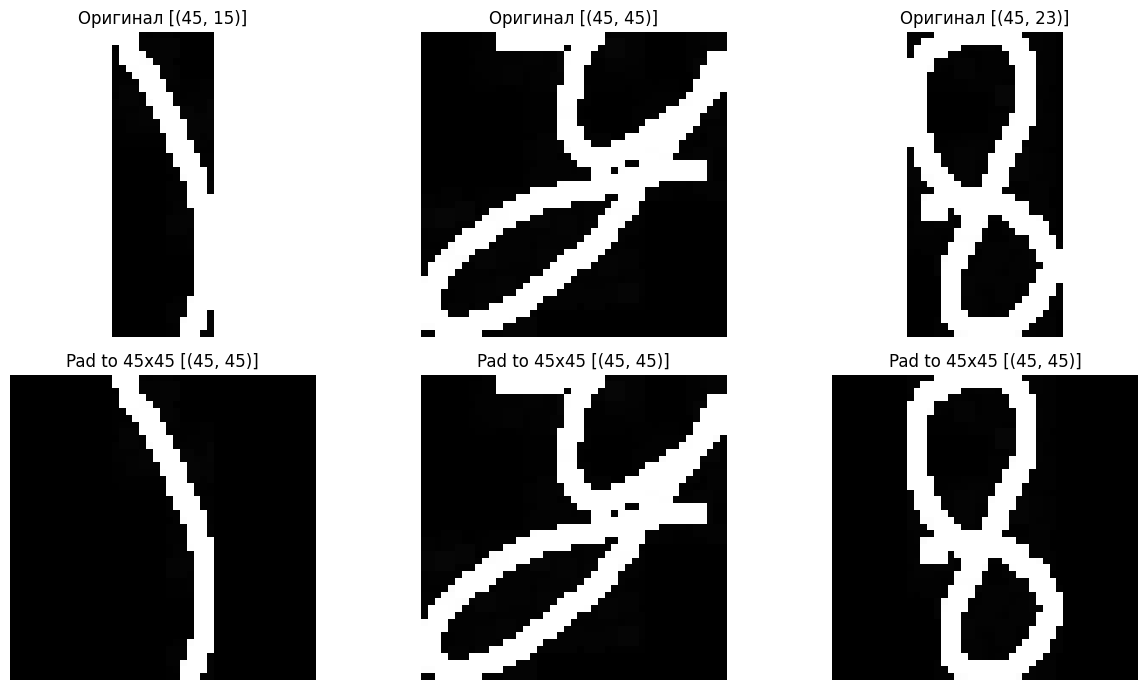

In [11]:
res_objects = []
print(f"→ Детектируем объекты на строке: '{text_seq}'")

proc_img = cv2.bitwise_not(cv2.erode(stitched_img, np.ones((3,3), np.uint8), iterations=1))
proc_img_rgb = cv2.cvtColor(proc_img, cv2.COLOR_GRAY2RGB)
ret, threshed = cv2.threshold(proc_img_rgb, 127, 255, 0)
conts, _ = cv2.findContours(threshed[:,:,0], cv2.RETR_EXTERNAL, 2)
sorted_conts = sorted(conts, key=lambda cnt: cv2.boundingRect(cnt)[0])
crops_info = []
for cnt in sorted_conts:
    x, y, w, h = cv2.boundingRect(cnt)
    while w > 45:
        w -= 1
    if w * h > 50:
        cv2.rectangle(proc_img_rgb, (x, y), (x + w, y + h), (175, 30, 210), 1)
        crops_info.append([x, y, w, h])

plt.figure(figsize=(10, 3))
plt.imshow(proc_img_rgb)
plt.title("→ Контуры и bounding box детектированных символов")
plt.axis('off')
plt.show()

detected_symbols = []
for i, (x, y, w, h) in enumerate(crops_info):
    crop_img = proc_img[y:y + h, x:x + w]
    plt.figure(figsize=(3, 2))
    plt.imshow(crop_img, cmap='gray')
    plt.title(f"Символ#{i + 1}")
    plt.axis('off')
    detected_symbols.append((x, crop_img))
    plt.show()

batch_data = [{
    'seq_text': text_seq,
    'objects': detected_symbols
}]

def pad_to_square(img, out_size=45):
    h, w = img.shape
    result = np.zeros((out_size, out_size), dtype=np.uint8)
    y0 = (out_size - h) // 2
    x0 = (out_size - w) // 2
    result[y0:y0+h, x0:x0+w] = img
    return result

data_padded = []
symbols_sorted = sorted(batch_data[0]['objects'], key=lambda el: el[0])
padded = []
for x, img in symbols_sorted:
    padded.append((x, pad_to_square(img)))

data_padded.append({
    'seq_text': batch_data[0]['seq_text'],
    'objects': padded
})

fig, axes = plt.subplots(2, min(3, len(padded)), figsize=(13, 7))
for i in range(min(3, len(padded))):
    axes[0, i].imshow(batch_data[0]['objects'][i][1], cmap='gray')
    axes[0, i].set_title(f'Оригинал [{batch_data[0]["objects"][i][1].shape}]')
    axes[0, i].axis('off')
    axes[1, i].imshow(padded[i][1], cmap='gray')
    axes[1, i].set_title(f'Pad to 45x45 [{padded[i][1].shape}]')
    axes[1, i].axis('off')
plt.tight_layout()
plt.show()

→ Обучающая размерность: (180225, 2025), лейблов: 180225
→ Модель k=1 обучена!
→ Модель k=3 обучена!
→ Модель k=5 обучена!
→ Модель k=7 обучена!

=== Классификация последовательности ===
Ожидается: ')y8335*8)'

------------------------------------------------
[Модель] knn-1
------------------------------------------------


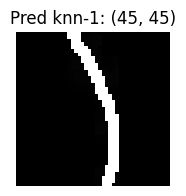

   [1] Выдано: ')'


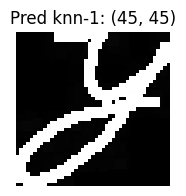

   [2] Выдано: 'y'


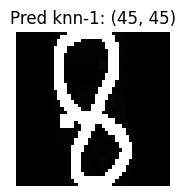

   [3] Выдано: '8'


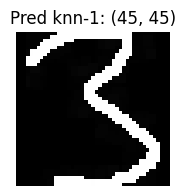

   [4] Выдано: '3'


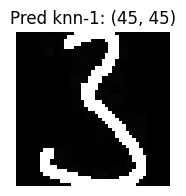

   [5] Выдано: '3'


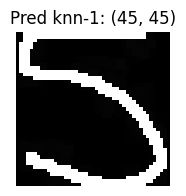

   [6] Выдано: '5'


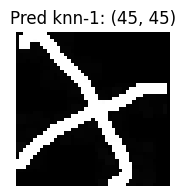

   [7] Выдано: '*'


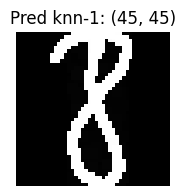

   [8] Выдано: '8'


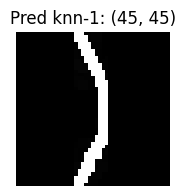

   [9] Выдано: ')'
→ Итог knn-1: 1.000 (9/9 совпадений)

------------------------------------------------
[Модель] knn-3
------------------------------------------------


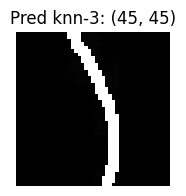

   [1] Выдано: ')'


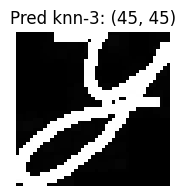

   [2] Выдано: 'y'


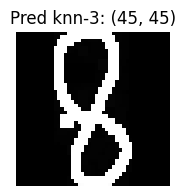

   [3] Выдано: '8'


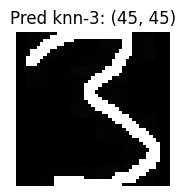

   [4] Выдано: '3'


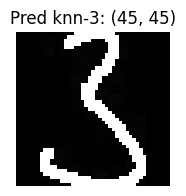

   [5] Выдано: '3'


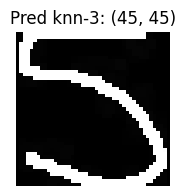

   [6] Выдано: '3'


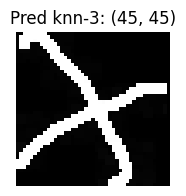

   [7] Выдано: '*'


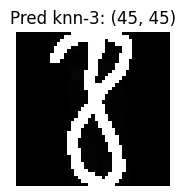

   [8] Выдано: '8'


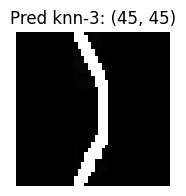

   [9] Выдано: ')'
     Ошибка в поз. 6: было '5', предсказано '3'
→ Итог knn-3: 0.889 (8/9 совпадений)

------------------------------------------------
[Модель] knn-5
------------------------------------------------


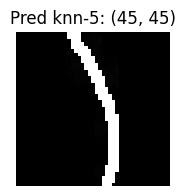

   [1] Выдано: ')'


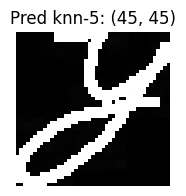

   [2] Выдано: 'y'


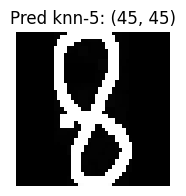

   [3] Выдано: '8'


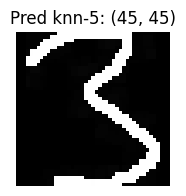

   [4] Выдано: '3'


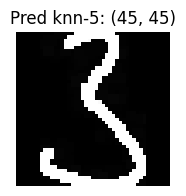

   [5] Выдано: '3'


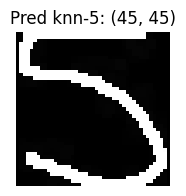

   [6] Выдано: '3'


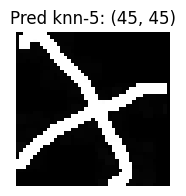

   [7] Выдано: '*'


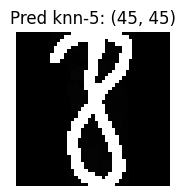

   [8] Выдано: '8'


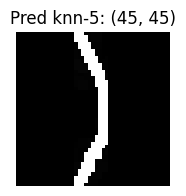

   [9] Выдано: ')'
     Ошибка в поз. 6: было '5', предсказано '3'
→ Итог knn-5: 0.889 (8/9 совпадений)

------------------------------------------------
[Модель] knn-7
------------------------------------------------


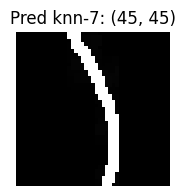

   [1] Выдано: ')'


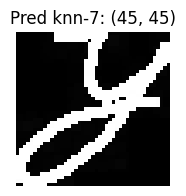

   [2] Выдано: 'y'


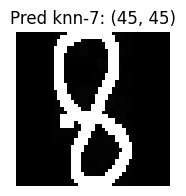

   [3] Выдано: '8'


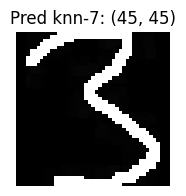

   [4] Выдано: '3'


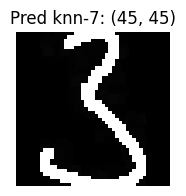

   [5] Выдано: '3'


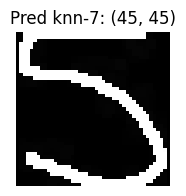

   [6] Выдано: '3'


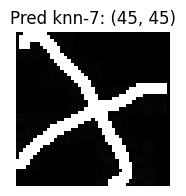

   [7] Выдано: 'x'


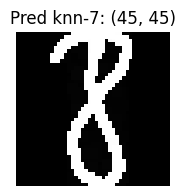

   [8] Выдано: '8'


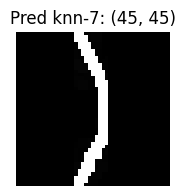

   [9] Выдано: ')'
     Ошибка в поз. 6: было '5', предсказано '3'
     Ошибка в поз. 7: было '*', предсказано 'x'
→ Итог knn-7: 0.778 (7/9 совпадений)

→ Сравнение моделей по точности
knn-1  | Точность: 100.00% | 9/9 | ')y8335*8)'
knn-3  | Точность: 88.89% | 8/9 | ')y8333*8)'
knn-5  | Точность: 88.89% | 8/9 | ')y8333*8)'
knn-7  | Точность: 77.78% | 7/9 | ')y8333x8)'


In [12]:
def prepare_training(base_dir, labels, train_ratio=0.8):
    feats, targets = [], []
    for label in labels:
        dir_ = os.path.join(base_dir, label)
        images = sorted([f for f in os.listdir(dir_) if os.path.isfile(os.path.join(dir_, f))])
        cut_idx = int(len(images) * train_ratio)
        subset = images[:cut_idx]
        for img_file in subset:
            img_path = os.path.join(dir_, img_file)
            arr = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if arr is not None:
                feats.append(arr.flatten())
                lab = 'x' if label == 'X' else '*' if label == 'times' else label
                targets.append(lab)
    return np.array(feats), np.array(targets)

labels = ['0','1','2','3','4','5','6','7','8','9','+','-','times','t','X','y','w','h','(',')',',']
X_tr, y_tr = prepare_training(r'C:\Users\smeta\Downloads\data', labels, 0.8)
print(f"→ Обучающая размерность: {X_tr.shape}, лейблов: {len(y_tr)}")

knn_1 = KNeighborsClassifier(n_neighbors=1)
knn_3 = KNeighborsClassifier(n_neighbors=3)
knn_5 = KNeighborsClassifier(n_neighbors=5)
knn_7 = KNeighborsClassifier(n_neighbors=7)

for num, clf in zip([1,3,5,7], [knn_1,knn_3,knn_5,knn_7]):
    clf.fit(X_tr, y_tr)
    print(f"→ Модель k={num} обучена!")

def run_inference(classifier, image):
    im_flip = cv2.bitwise_not(image)
    flat = im_flip.flatten()
    return classifier.predict([flat])[0]

seq_info = data_padded[0]
seq_true = seq_info['seq_text']
seq_imgs = seq_info['objects']

print(f"\n=== Классификация последовательности ===")
print(f"Ожидается: '{seq_true}'")

clf_dict = {'knn-1': knn_1, 'knn-3': knn_3, 'knn-5': knn_5, 'knn-7': knn_7}
results = {}

for model_name, model in clf_dict.items():
    print(f"\n{'-'*48}\n[Модель] {model_name}\n{'-'*48}")
    predicts = []
    for idx, (x, img) in enumerate(seq_imgs):
        plt.figure(figsize=(3, 2))
        plt.imshow(img, cmap='gray')
        plt.title(f'Pred {model_name}: {img.shape}')
        plt.axis('off')
        plt.show()
        pred_c = run_inference(model, img)
        predicts.append(pred_c)
        print(f"   [{idx+1}] Выдано: '{pred_c}'")
    pred_seq = ''.join(predicts)
    correct = sum(1 for a,b in zip(seq_true, pred_seq) if a == b)
    total = len(seq_true)
    acc = correct / total
    if seq_true != pred_seq:
        for k, (et, pt) in enumerate(zip(seq_true, pred_seq)):
            if et != pt:
                print(f"     Ошибка в поз. {k+1}: было '{et}', предсказано '{pt}'")
    print(f"→ Итог {model_name}: {acc:.3f} ({correct}/{total} совпадений)")
    results[model_name] = {'pred_seq': pred_seq, 'acc': acc, 'correct': correct, 'total': total}

print(f"\n{'='*48}\n→ Сравнение моделей по точности\n{'='*48}")
for nm, res in sorted(results.items(), key=lambda x: x[1]['acc'], reverse=True):
    print(f"{nm:6} | Точность: {res['acc']*100:.2f}% | {res['correct']}/{res['total']} | '{res['pred_seq']}'")